Format largely inspired by David Wang's code for creating surrogate model for toray

# Package imports

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import h5py

import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.utils import shuffle
from sklearn.metrics import r2_score

from tqdm import tqdm
import time
import math
import random
import os

from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import ParameterGrid

In [16]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics

# Import dataframe

In [4]:
file = h5py.File('training_inputs.h5', 'r')

In [5]:
print(np.array(file.keys()))

<KeysViewHDF5 ['33384', '33385', '33386', '33388', '33389', '33390', '33391', '33394', '33395', '33396', '33397', '33398', '33431', '33432', '33433', '33434', '33435', '33436', '33437', '33438', '33439', '33440', '33441', '33443', '33446', '33472', '33474', '33475', '33476', '33477', '33482', '33483', '33485', '33487', '33489', '33496', '33497', '33498', '33500', '33503', '33505', '33509', '33516', '33527', '33528', '33531', '33532', '33533', '33542', '33543', '33544', '33545', '33546', '33547', '33548', '33549', '33550', '33552', '33553', '33554', '33555', '33556', '33557', '33558', '33562', '33563', '33564', '33565', '33576', '33590', '33591', '33592', '33596', '33642', '33644', '33648', '33649', '33650', '33651', '33652', '33653', '33655', '33656', '33657', '33661', '33662', '33663', '33664', '33665', '33666', '33667', '33668', '33669', '33672', '33673', '33674', '33675', '33676', '33678', '33679', '33680', '33681', '33688', '33689', '33690', '33691', '33692', '33693', '33694', '336

In [ ]:
print(np.array(file['34374'].keys()))

<KeysViewHDF5 ['1.653', '1.7550000000000001', '1.857', '1.95', '2.052', '2.154', '2.2560000000000002', '2.35', '2.452', '2.5540000000000003', '2.656', '2.75', '2.851', '2.953', '3.055', '3.157', '3.251', '3.353', '3.455', '3.557', '3.6510000000000002', '3.753', '3.855', '3.9570000000000003', '4.05', '4.152', '4.2540000000000004', '4.356', '4.449', '4.5520000000000005', '4.6530000000000005', '4.756', '4.857', '4.9510000000000005', '5.053', '5.155', '5.257']>


In [28]:
h5_param_keys = np.array(file['33384']['1.756'].keys())
print(h5_param_keys)

<KeysViewHDF5 ['Br', 'Bt', 'Bt_center', 'Bz', 'Ip', 'PSIRZ_norm', 'R', 'R0', 'R_in', 'R_mid', 'R_out', 'Te_pos', 'Te_val', 'Z', 'Z0', 'aminor', 'bcentr_2', 'betan', 'betan_2', 'betap', 'elong', 'elongm', 'gapbot', 'gapin', 'gapout', 'gaptop', 'ipmhd', 'li', 'ltri', 'ne_pos', 'ne_val', 'rcencm', 'rcntr', 'rho_pol', 'rho_tor', 'rmidin', 'rmidout', 'rseps', 'utri', 'volume', 'wmhd', 'zcntr', 'zm', 'zseps']>


In [12]:
Br_test = np.array(file['33384']['1.756']['Br'])
print(Br_test)
print(Br_test.shape)

[[-0.06265033 -0.07479593 -0.08284204 ...  0.00099237  0.00151645
   0.0019647 ]
 [-0.06706729 -0.07755297 -0.08311465 ...  0.00264143  0.00320266
   0.00358989]
 [-0.07960579 -0.08335995 -0.08286235 ...  0.00654404  0.0068644
   0.00703625]
 ...
 [ 0.06529678  0.06918781  0.06889316 ...  0.00108553  0.00173815
   0.0025635 ]
 [ 0.04985824  0.06046062  0.06627885 ...  0.00443735  0.00488813
   0.00555654]
 [ 0.04359592  0.05585859  0.06425403 ...  0.00574076  0.00627059
   0.00690308]]
(33, 33)


Start with combining data for just EC2 and X mode

In [7]:
df = pd.read_csv('torbeam_df/34374_data.csv')

In [8]:
temp = df[df['gyro'] == 'EC2']
temp[temp['mode'] == -1]

,Unnamed: 0,rho_pol,psiN,rho_tor,R,Z,total_CD,absorbed_power_frac,CD_eta,pol_ang,tor_ang,mode,time,shot,gyro,freq
0,0,0.141199,0.019937,0.081435,1.838247,0.079480,2090.118754,1.0,0.004180,0.398481,-0.012812,-1,51456.0,34374,EC2,1.050000e+11
1,0,0.088642,0.007857,0.032094,1.837975,0.042554,2131.277443,1.0,0.004263,0.437755,-0.012812,-1,51456.0,34374,EC2,1.050000e+11
2,0,0.350386,0.122770,0.257235,1.843898,0.207335,1739.355528,1.0,0.003479,0.245794,-0.012812,-1,51456.0,34374,EC2,1.050000e+11
3,0,0.152156,0.023151,0.094564,1.838519,0.086481,2078.370303,1.0,0.004157,0.390873,-0.012812,-1,51456.0,34374,EC2,1.050000e+11
4,0,0.173423,0.030076,0.122847,1.839623,0.100265,2052.766204,1.0,0.004106,0.375912,-0.012812,-1,51456.0,34374,EC2,1.050000e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4194,0,0.125348,0.015712,0.066065,1.838648,0.035207,8374.255653,1.0,0.016749,0.451161,-0.068635,-1,9553.0,34374,EC2,1.050000e+11
4195,0,0.464913,0.216144,0.357314,1.852197,0.253245,5865.450889,1.0,0.011731,0.195330,-0.068635,-1,9553.0,34374,EC2,1.050000e+11
4196,0,0.447072,0.199873,0.342385,1.850677,0.242146,5947.700041,1.0,0.011895,0.209919,-0.068635,-1,9553.0,34374,EC2,1.050000e+11
4197,0,0.267040,0.071310,0.199094,1.843918,0.128824,7009.466950,1.0,0.014019,0.352110,-0.068635,-1,9553.0,34374,EC2,1.050000e+11


In [26]:
print(np.array(file['34374'].keys()))

<KeysViewHDF5 ['1.6560000000000001', '1.7550000000000001', '1.855', '1.955', '10.057', '10.156', '10.255', '10.355', '10.455', '10.555', '10.654', '10.753', '10.852', '10.951', '11.05', '11.158', '11.257', '11.356', '11.456', '11.555', '11.654', '11.753', '11.852', '11.951', '12.05', '12.149000000000001', '12.258000000000001', '12.358', '12.458', '12.558', '12.657', '12.756', '12.855', '12.955', '13.054', '13.153', '13.252', '13.351', '13.450000000000001', '13.558', '13.657', '13.756', '13.855', '13.954', '14.053', '14.152000000000001', '14.252', '14.351', '14.450000000000001', '14.55', '14.658', '14.757', '14.856', '14.955', '15.054', '15.154', '15.253', '15.353', '15.453000000000001', '15.552', '15.651', '15.751', '15.851', '15.951', '16.051000000000002', '16.15', '16.25', '16.35', '16.458000000000002', '16.558', '16.649', '16.75', '16.85', '16.95', '17.05', '17.150000000000002', '17.25', '17.35', '17.45', '17.55', '17.650000000000002', '17.75', '17.85', '17.95', '18.058', '18.157', 

In [33]:
len(file['34374'].keys())

531

In [36]:
df['time']

0       51456.0
1       51456.0
2       51456.0
3       51456.0
4       51456.0
         ...   
5923     9553.0
5924     9553.0
5925     9553.0
5926     9553.0
5927     9553.0
Name: time, Length: 5928, dtype: float64

In [34]:
np.unique(df['time'])

array([ 2352.,  9553., 51456.])

In [4]:
full_df = pd.read_csv('TORBEAM_all_df.csv')

In [12]:
temp = full_df[full_df['gyro'] == 'EC2']
temp = temp[temp['mode'] == -1]
temp

,Unnamed: 0,rho_pol,R,Z,CD_eta,pol_ang,tor_ang,gyro,mode,time,...,elong,gapin,gapout,gaptop,gapbot,li,ltri,utri,volume,wmhd
0,0,0.386395,1.732197,0.176420,0.023184,0.275472,-0.143863,EC2,-1,6494.0,...,1.973659,1.000000e+10,7.949647,45.040767,37.499530,1.060367,0.522887,0.369570,13386183.6,257656.819
1,1,0.267569,1.726815,-0.047142,0.025859,0.442036,-0.143863,EC2,-1,6494.0,...,1.973659,1.000000e+10,7.949647,45.040767,37.499530,1.060367,0.522887,0.369570,13386183.6,257656.819
2,2,0.417614,1.735665,0.207672,0.022597,0.244748,-0.143863,EC2,-1,6494.0,...,1.973659,1.000000e+10,7.949647,45.040767,37.499530,1.060367,0.522887,0.369570,13386183.6,257656.819
3,3,0.292321,1.727766,-0.111077,0.024718,0.476505,-0.143863,EC2,-1,6494.0,...,1.973659,1.000000e+10,7.949647,45.040767,37.499530,1.060367,0.522887,0.369570,13386183.6,257656.819
4,4,0.489211,1.736356,0.267942,0.021069,0.180526,-0.143863,EC2,-1,6494.0,...,1.973659,1.000000e+10,7.949647,45.040767,37.499530,1.060367,0.522887,0.369570,13386183.6,257656.819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927376,927376,0.317231,1.707376,-0.073220,0.018352,0.454654,-0.088325,EC2,-1,9227.0,...,1.922403,1.000000e+10,8.688286,49.019197,39.357015,0.993877,0.570798,0.362073,13126724.9,280962.370
927377,927377,0.316127,1.709019,0.049801,0.019155,0.372828,-0.088325,EC2,-1,9227.0,...,1.922403,1.000000e+10,8.688286,49.019197,39.357015,0.993877,0.570798,0.362073,13126724.9,280962.370
927378,927378,0.350750,1.709540,-0.145107,0.016497,0.495757,-0.088325,EC2,-1,9227.0,...,1.922403,1.000000e+10,8.688286,49.019197,39.357015,0.993877,0.570798,0.362073,13126724.9,280962.370
927379,927379,0.492018,1.718064,0.276742,0.015733,0.164368,-0.088325,EC2,-1,9227.0,...,1.922403,1.000000e+10,8.688286,49.019197,39.357015,0.993877,0.570798,0.362073,13126724.9,280962.370


In [13]:
print(full_df.columns)

Index(['Unnamed: 0', 'rho_pol', 'R', 'Z', 'CD_eta', 'pol_ang', 'tor_ang',
       'gyro', 'mode', 'time', 'shot', 'freq', 'Bt_center', 'ne_val_0',
       'ne_val_1', 'ne_val_2', 'ne_val_3', 'ne_val_4', 'ne_val_5', 'ne_val_6',
       'ne_val_7', 'ne_val_8', 'ne_val_9', 'ne_val_10', 'ne_val_11',
       'ne_val_12', 'ne_val_13', 'ne_val_14', 'ne_val_15', 'ne_val_16',
       'ne_val_17', 'ne_val_18', 'ne_val_19', 'ne_val_20', 'Ip', 'R0', 'R_in',
       'R_out', 'Z0', 'aminor', 'betan', 'elong', 'gapin', 'gapout', 'gaptop',
       'gapbot', 'li', 'ltri', 'utri', 'volume', 'wmhd'],
      dtype='object')


In [ ]:
def split_data(data):
    # split chronologically before shuffling

    data = data.sort_values(by='shot', ascending=False)
    
    # Decide how large to make validation and test sets
    total_count = data.shape[0]
    n_val = math.floor(total_count * 0.10)
    n_test = math.floor(total_count * 0.10)
    print(n_val)
    
    # separate data into test, validation, and training sets
    data_test = data.iloc[:n_test]
    data_val = data.iloc[n_test:n_test+n_val]
    data_train = data.iloc[n_test+n_val:]
    
    training_size = len(data_train)
    
    print("Training Set Size:", len(data_train))
    print("Validation Set Size:", len(data_val))
    print("Testing Set Size:", len(data_test))
    print("Total:", len(data_train)+len(data_test)+len(data_val))

    return data_train, data_val, data_test

Epoch 1/500


/home/jj5684/.conda/envs/torch-env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


485/485 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4203896809455616.0000 - mae: 6573777.5000 - val_loss: 0.7854 - val_mae: 0.5494
Epoch 2/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7842 - mae: 0.5492 - val_loss: 0.7845 - val_mae: 0.5492
Epoch 3/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7833 - mae: 0.5487 - val_loss: 0.7836 - val_mae: 0.5490
Epoch 4/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7824 - mae: 0.5485 - val_loss: 0.7827 - val_mae: 0.5487
Epoch 5/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7809 - mae: 0.5478 - val_loss: 0.7818 - val_mae: 0.5485
Epoch 6/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7812 - mae: 0.5485 - val_loss: 0.7808 - val_mae: 0.5482
Epoch 7/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7802 - mae: 0.5480 - val_loss: 0.7799 - val_mae: 0.5480
Epoch 8/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7785 - mae: 0.5476 - val_loss: 0.7789 - val_mae: 0.5477
Epoch 9/500
485/485 ━━━━━━━━━━━━━━━━━━━

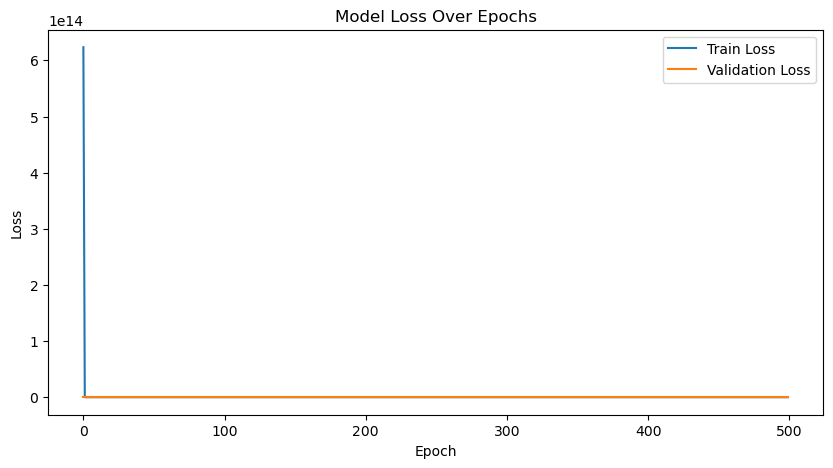

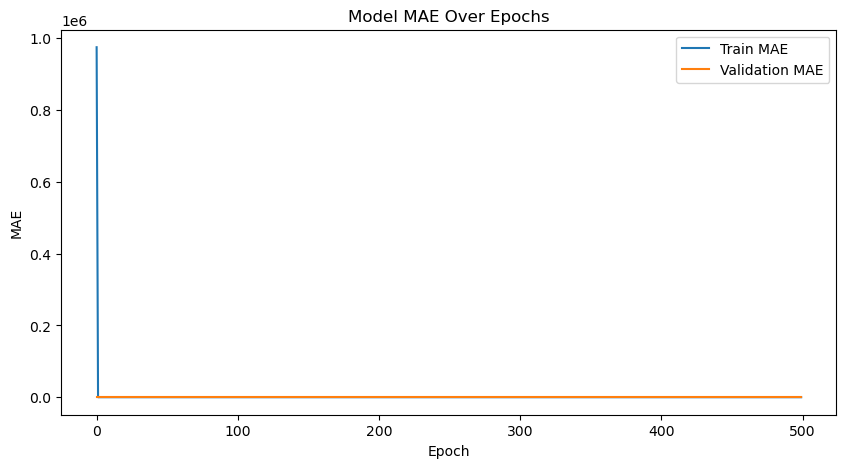

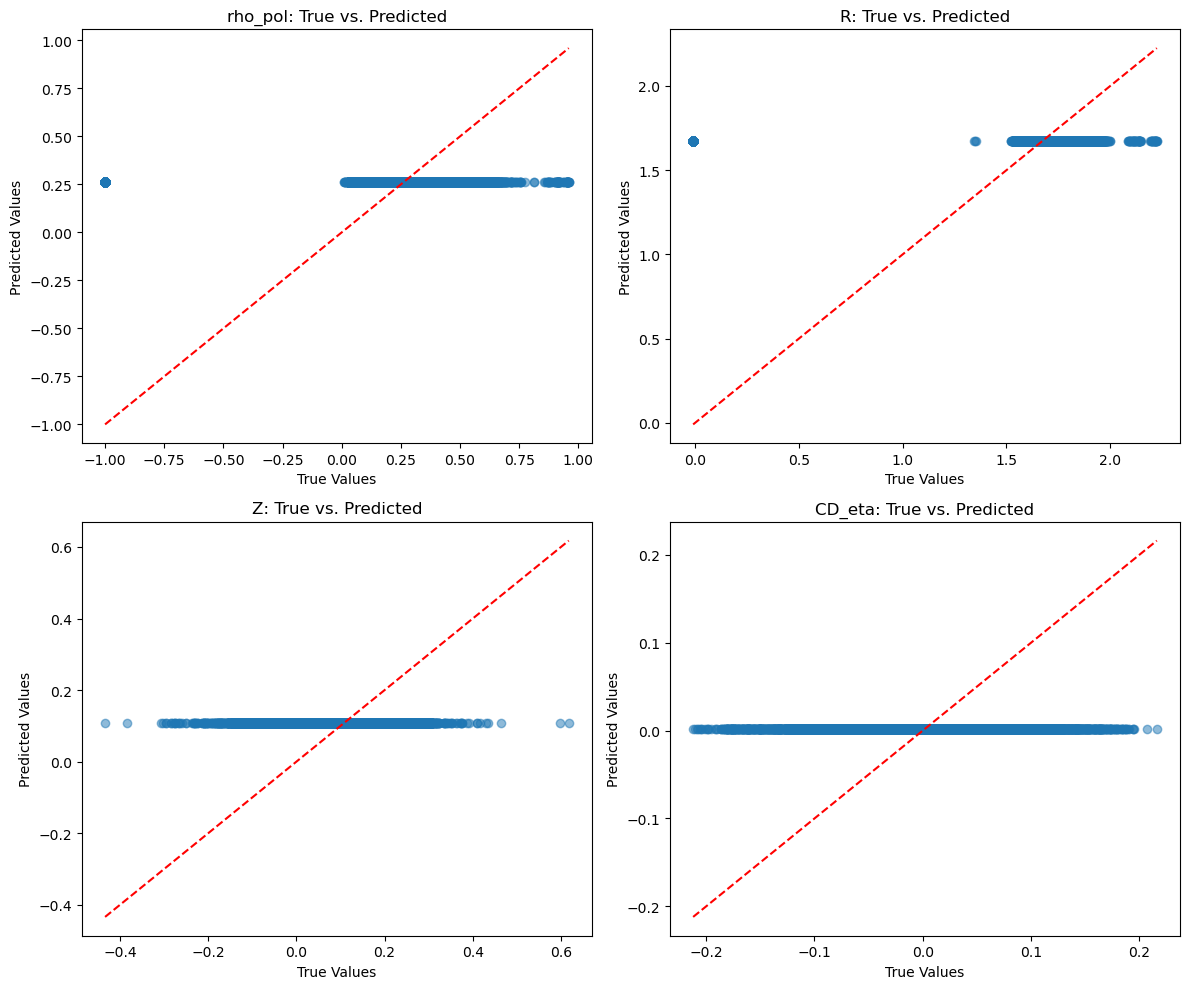

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Define your input and output columns
input_columns = [
    'pol_ang', 'tor_ang', 'Bt_center', 'Ip', 'R0', 'R_in', 'R_out', 'Z0', 'aminor', 'betan', 
    'elong', 'gapin', 'gapout', 'gaptop', 'gapbot', 'li', 'ltri', 'utri', 'volume', 'wmhd', 
    'ne_val_0', 'ne_val_1', 'ne_val_2', 'ne_val_3', 'ne_val_4', 'ne_val_5', 'ne_val_6', 
    'ne_val_7', 'ne_val_8', 'ne_val_9', 'ne_val_10', 'ne_val_11', 'ne_val_12', 'ne_val_13', 
    'ne_val_14', 'ne_val_15', 'ne_val_16', 'ne_val_17', 'ne_val_18', 'ne_val_19', 'ne_val_20'
]

output_columns = ['rho_pol', 'R', 'Z', 'CD_eta']

# Load the data
df_initial = pd.read_csv("TORBEAM_all_df.csv")  # replace with your CSV file path

# Narrow down to a specific gyro and mode
temp = df_initial[df_initial['gyro'] == 'EC2']
temp = temp[temp['mode'] == -1]
df = temp

# Extract input features and output targets
X = df[input_columns].values
y = df[output_columns].values

# Optional: Perform a train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Optional: Normalize features (recommended for neural networks)
# scaler_X = StandardScaler()
# X_train = scaler_X.fit_transform(X_train)
# X_val = scaler_X.transform(X_val)
# X_test = scaler_X.transform(X_test)

# If desired, you can also scale the outputs, especially if their ranges differ significantly.
# scaler_y = StandardScaler()
# y_train = scaler_y.fit_transform(y_train)
# y_val = scaler_y.transform(y_val)
# y_test = scaler_y.transform(y_test)

# Build a simple feed-forward neural network
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(output_columns), activation='linear'))  # linear output for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-6), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=256,
    verbose=1
)

# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# If you scaled the outputs, don't forget to invert the scaling of predictions for interpretation:
y_pred = model.predict(X_test)


import matplotlib.pyplot as plt

# Plot training & validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# If you also have mae or another metric:
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

output_names = ['rho_pol', 'R', 'Z', 'CD_eta']
for i, ax in enumerate(axs.flat):
    ax.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    ax.set_title(f'{output_names[i]}: True vs. Predicted')
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    # Optionally draw a perfect-fit line
    min_val = min(y_test[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test[:, i].max(), y_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.tight_layout()
plt.show()


In [31]:
np.unique(y_pred)

array([0.00219641, 0.10711956, 0.2608335 , 1.6698617 ], dtype=float32)

In [24]:
history.history

{'loss': [1.0003407001495361,
  1.0000495910644531,
  1.0000451803207397,
  1.0000356435775757,
  1.0000568628311157,
  1.000068187713623,
  1.0000556707382202,
  1.0000444650650024,
  1.0000495910644531,
  1.0000452995300293,
  1.0000559091567993,
  1.0000306367874146,
  1.0000832080841064,
  1.0000602006912231,
  1.0000537633895874,
  1.000056266784668,
  1.0000524520874023,
  1.0000663995742798,
  1.000056505203247,
  1.0000468492507935,
  1.0000566244125366,
  1.0000258684158325,
  1.0000340938568115,
  1.0000536441802979,
  1.0000488758087158,
  1.0000497102737427,
  1.0000494718551636,
  1.0000393390655518,
  1.0000468492507935,
  1.0000604391098022,
  1.0000439882278442,
  1.0000406503677368,
  1.000060796737671,
  1.000056266784668,
  1.0000513792037964,
  1.0000150203704834,
  1.000044822692871,
  1.0000455379486084,
  1.0000559091567993,
  1.0000479221343994,
  1.0000531673431396,
  1.0000503063201904,
  1.0000604391098022,
  1.0000466108322144,
  1.0000355243682861,
  1.0000